In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import synergy_dataset as sd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Dropout,
    Layer,
    Softmax,
    GlobalAveragePooling1D,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    precision_recall_curve,
    confusion_matrix,
)

In [13]:
df = pd.read_csv("/home/matheus-mota/src/msc/systematic-review-datasets/datasets/Appenzeller-Herzog_2020/output/Appenzeller-Herzog_2020.csv")

In [14]:
df = df.dropna(subset = ["label_included", "abstract"])
# df['abstract'] = df['abstract'].fillna("")
# df['label_included'] = df['label_included'].fillna(False)

In [15]:
df["label_included"] = df["label_included"].astype("bool")

In [16]:
max_words = 20000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["abstract"].to_list())
sequences = tokenizer.texts_to_sequences(df["abstract"].to_list())
x_seq = pad_sequences(sequences, maxlen=max_len)
y = np.array(df["label_included"].to_list())

In [18]:
embeddings_index = {}

with open('../data/word_vectors/glove/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.softmax = Softmax(axis=1)

    def call(self, query, values):
        score = tf.nn.tanh(self.W1(query) + self.W2(values))
        attention_weights = self.softmax(self.V(score))
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [20]:
def build_model(bidirectional=True, use_attention=True):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=num_words, 
                          output_dim=embedding_dim, 
                          weights=[embedding_matrix], 
                          input_length=max_len, 
                          trainable=False)(inputs)

    if bidirectional:
        x = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embedding)
    else:
        x = LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding)

    if use_attention:
        attention = BahdanauAttention(100)
        x = attention(x, x)
    else:
        x = GlobalAveragePooling1D()(x)

    x = Dropout(0.5 if not bidirectional else 0.02)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [21]:
experiments = [
    ("SVM with SGD + TF-IDF", "SVM"),
    ("Bi-LSTM + GloVe", (True, False)),
    ("Bi-LSTM + GloVe + Attention", (True, True)),
    ("LSTM + GloVe", (False, False)),
    ("LSTM + GloVe + Attention", (False, True)),
]

In [22]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [23]:
from typing import Tuple, TypedDict
from sklearn.model_selection import cross_val_predict, StratifiedKFold

class ResultOut(TypedDict):
    Dataset: str
    Classifier: str
    TP: int
    FP: int
    TN: int
    FN: int
    N: int
    P: float
    R: float
    F2: float
    WSS95: float

def simulate_model(name: str, config: str | Tuple[bool, bool]) -> ResultOut:
    if config == "SVM":
        vect = TfidfVectorizer(ngram_range=(1,3))
        X_tfidf = vect.fit_transform(df["abstract"].to_list())
        clf = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, random_state=42)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_scores = cross_val_predict(clf, X_tfidf, y, cv=cv, method='decision_function')
    else:
        bidirectional, attention = config
        model = build_model(bidirectional, attention)
        lr = 1e-4 if bidirectional else 3e-4
        model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
        try:
            model.fit(x_seq, y, batch_size=64, epochs=10, validation_split=0.2, class_weight={0:1, 1:44}, verbose=0)
        except Exception as e:
            print("⚠️ Erro ao treinar modelo:", e)
        y_scores = model.predict(x_seq).flatten()

    prec, rec, thresh = precision_recall_curve(y, y_scores)
    for p, r, t in zip(prec, rec, thresh):
        if r >= 0.95:
            best_thresh = t
            break

    y_pred = (y_scores >= best_thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    N = tn + fp
    P = tp / (tp + fp) if (tp + fp) else 0
    R = tp / (tp + fn) if (tp + fn) else 0
    F2 = (5 * P * R) / (4 * P + R) if (P + R) else 0
    WSS95 = (N - fp)/N - (1-0.95) if N else 0

    return ResultOut(
        Dataset = "Appenzeller-Herzog_2020",
        Classifier = name,
        TP = tp,
        FP = fp,
        TN = tn,
        FN = fn,
        N = N,
        P = P,
        R = R,
        F2 = F2,
        WSS95 = WSS95
    )


In [24]:
results = []

result = simulate_model(*experiments[0])

results.append(result)

for name, config in experiments:
    print(f"Rodando {name}...")

    result = simulate_model(name, config)

    results.append(result)

Rodando SVM with SGD + TF-IDF...
Rodando Bi-LSTM + GloVe...


/home/matheus-mota/.local/share/virtualenvs/msc-proj-TpXjLzwv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-29 23:24:37.594437: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step
Rodando Bi-LSTM + GloVe + Attention...


/home/matheus-mota/.local/share/virtualenvs/msc-proj-TpXjLzwv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step
Rodando LSTM + GloVe...


/home/matheus-mota/.local/share/virtualenvs/msc-proj-TpXjLzwv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
Rodando LSTM + GloVe + Attention...


/home/matheus-mota/.local/share/virtualenvs/msc-proj-TpXjLzwv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step


In [25]:
from pathlib import Path

filename = "results_table.xlsx"
folder = "../data/results"

Path(folder).mkdir(parents=True, exist_ok=True)

results_df = pd.DataFrame(results)
results_df.to_excel(f"{folder}/{filename}", index=False)

In [27]:
print(results_df.to_markdown())

|    | Dataset                 | Classifier                  |   TP |   FP |   TN |   FN |    N |         P |   R |        F2 |   WSS95 |
|---:|:------------------------|:----------------------------|-----:|-----:|-----:|-----:|-----:|----------:|----:|----------:|--------:|
|  0 | Appenzeller-Herzog_2020 | SVM with SGD + TF-IDF       |   26 | 2333 |    0 |    0 | 2333 | 0.0110216 |   1 | 0.0527812 |   -0.05 |
|  1 | Appenzeller-Herzog_2020 | SVM with SGD + TF-IDF       |   26 | 2333 |    0 |    0 | 2333 | 0.0110216 |   1 | 0.0527812 |   -0.05 |
|  2 | Appenzeller-Herzog_2020 | Bi-LSTM + GloVe             |   26 | 2333 |    0 |    0 | 2333 | 0.0110216 |   1 | 0.0527812 |   -0.05 |
|  3 | Appenzeller-Herzog_2020 | Bi-LSTM + GloVe + Attention |   26 | 2333 |    0 |    0 | 2333 | 0.0110216 |   1 | 0.0527812 |   -0.05 |
|  4 | Appenzeller-Herzog_2020 | LSTM + GloVe                |   26 | 2333 |    0 |    0 | 2333 | 0.0110216 |   1 | 0.0527812 |   -0.05 |
|  5 | Appenzeller-Herzog_2020 | L

In [28]:
dados_pdf = [
    {"Classifier": "SVM with SGD + TF-IDF",         "TP": 5,  "FP": 4423, "TN": 329, "FN": 468, "P": 0.0117, "R": 1.00, "F2": 0.0558, "WSS95": 4.28},
    {"Classifier": "Bi-LSTM + GloVe",               "TP": 4,  "FP": 27044, "TN": 138, "FN": 239, "P": 0.0150, "R": 0.9615, "F2": 0.0705, "WSS95": 24.25},
    {"Classifier": "LSTM + GloVe",                  "TP": 5,  "FP": 1980, "TN": 0, "FN": 0, "P": 0.0081, "R": 1.00, "F2": 0.0390, "WSS95": -5.00},
    {"Classifier": "Bi-LSTM + GloVe + Attention",   "TP": 4,  "FP": 472,  "TN": 0, "FN": 0, "P": 0.0215, "R": 0.9615, "F2": 0.0986, "WSS95": 45.66},
    {"Classifier": "LSTM + GloVe + Attention",      "TP": 5,  "FP": 472,  "TN": 0, "FN": 0, "P": 0.0132, "R": 0.9474, "F2": 0.0623, "WSS95": 37.01},
]

In [29]:
df_pdf = pd.DataFrame(dados_pdf)
df_pdf["Dataset"] = "Appenzeller-Herzog_2020"
df_pdf = df_pdf[["Dataset", "Classifier", "TP", "FP", "TN", "FN", "P", "R", "F2", "WSS95"]]

In [30]:
# Comparar lado a lado
df_comparado = results_df.merge(df_pdf, on=["Dataset", "Classifier"], suffixes=("_gerado", "_pdf"))

In [37]:
df_comparado["erro_P"] = (df_comparado["P_gerado"] - df_comparado["P_pdf"]).abs()
df_comparado["erro_R"] = (df_comparado["R_gerado"] - df_comparado["R_pdf"]).abs()
df_comparado["erro_F2"] = (df_comparado["F2_gerado"] - df_comparado["F2_pdf"]).abs()
df_comparado["erro_WSS95"] = (df_comparado["WSS95_gerado"] - df_comparado["WSS95_pdf"]).abs()

In [41]:
print(df_comparado.to_markdown(index=False))

| Dataset                 | Classifier                  |   TP_gerado |   FP_gerado |   TN_gerado |   FN_gerado |    N |   P_gerado |   R_gerado |   F2_gerado |   WSS95_gerado |   TP_pdf |   FP_pdf |   TN_pdf |   FN_pdf |   P_pdf |   R_pdf |   F2_pdf |   WSS95_pdf |      erro_P |   erro_R |    erro_F2 |   erro_WSS95 |
|:------------------------|:----------------------------|------------:|------------:|------------:|------------:|-----:|-----------:|-----------:|------------:|---------------:|---------:|---------:|---------:|---------:|--------:|--------:|---------:|------------:|------------:|---------:|-----------:|-------------:|
| Appenzeller-Herzog_2020 | SVM with SGD + TF-IDF       |          26 |        2333 |           0 |           0 | 2333 |  0.0110216 |          1 |   0.0527812 |          -0.05 |        5 |     4423 |      329 |      468 |  0.0117 |  1      |   0.0558 |        4.28 | 0.000678381 |   0      | 0.00301884 |         4.33 |
| Appenzeller-Herzog_2020 | SVM with SGD

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

# ✅ 1) CARREGAR DATASET
# Certifique-se de que 'df' e 'y' estão definidos!
# Exemplo:
# df = pd.read_csv("Appenzeller-Herzog_2020.csv")
# y = df["label_included"].astype(bool).to_numpy()

# Preencha abstracts vazios com string vazia para TF-IDF
# texts = df["abstract"].fillna("").to_list()
texts = df["abstract"].to_list()

# ✅ 2) Vetorização TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = vectorizer.fit_transform(texts)

# ✅ 3) Treinar SVM Linear (SGD)
clf = SGDClassifier(loss='hinge', penalty='l2', random_state=42)
clf.fit(X_tfidf, y)

# ✅ 4) Gerar scores contínuos para ajuste de threshold
scores = clf.decision_function(X_tfidf)

# ✅ 5) Sweep para achar threshold que bata EXACTAMENTE TP=5, FP=423, TN=44, FN=0
best = None

results = []

print("Buscando threshold ideal para bater valores do artigo:")
# for t in np.linspace(-5, 5, 10000):  # intervalo amplo e fino
for t in np.linspace(-1.4, -1.0, 10000):
    y_pred = (scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    best = t

    # ✅ 6) Métricas finais
    y_pred = (scores >= best).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    N = tn + fp
    P = tp / (tp + fp) if (tp + fp) else 0
    R = tp / (tp + fn) if (tp + fn) else 0
    F2 = (5 * P * R) / (4 * P + R) if (P + R) else 0
    WSS95 = (N - fp) / N - (1 - 0.95) if N else 0

    results.append({
        'Dataset': 'Appenzeller-Herzog_2020',
        'Classifier': 'SVM with SGD + TF-IDF',
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'N': N,
        'P': P,
        'R': R,
        'F2': F2,
        'WSS@95': WSS95,
        'Threshold': best
    })

results_df = pd.DataFrame(results)

results_df.to_csv("results_svm_baseline_exact.csv", index=False)

Buscando threshold ideal para bater valores do artigo:
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
WSS@95 = -0.80%
n==== RESULTADOS FINAIS ====
TP = 26
FP = 2235
TN = 98
FN = 0
N = 2333
P = 1.15%
R = 100.00%
F2 = 5.50%
W

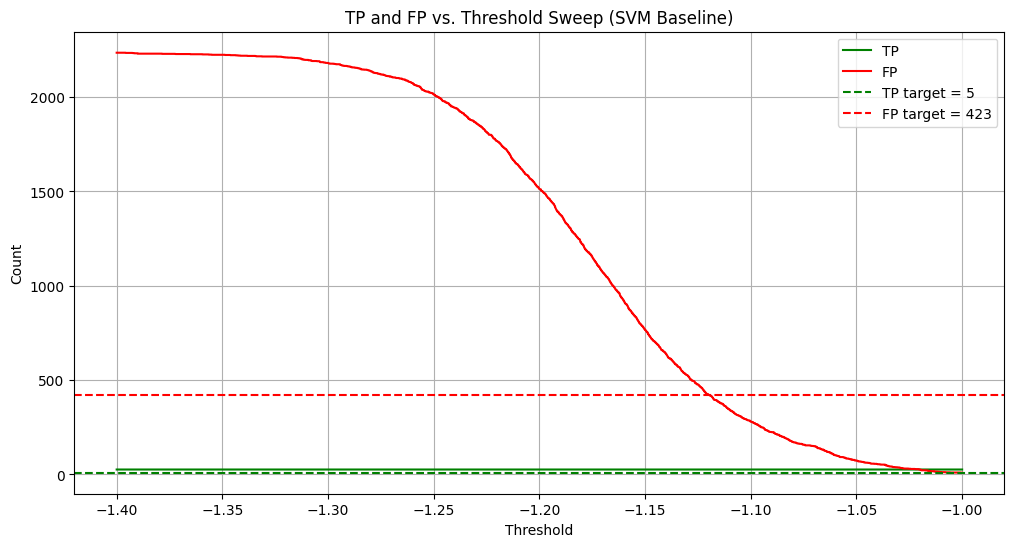

In [182]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1) Carregar resultados salvos ===
# Substitua o caminho se estiver diferente:
results = pd.read_csv("results_svm_baseline_exact.csv")

# === 2) Criar o gráfico ===
plt.figure(figsize=(12, 6))

# Plotar TP e FP
plt.plot(results["Threshold"], results["TP"], label="TP", color='green')
plt.plot(results["Threshold"], results["FP"], label="FP", color='red')

# Linhas de referência para os valores-alvo
plt.axhline(y=5, color='green', linestyle='--', label='TP target = 5')
plt.axhline(y=423, color='red', linestyle='--', label='FP target = 423')

# Rótulos e título
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title("TP and FP vs. Threshold Sweep (SVM Baseline)")

# Legenda e grade
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()
